In [2]:
# Credits: Some code adapted from the Intel Time Series Analysis course

%matplotlib inline

from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyflux as pf
import statsmodels as ss
import seaborn as sns
import sys
import warnings

warnings.filterwarnings("ignore")
matplotlib.rcParams['figure.figsize'] = (20, 5)

ModuleNotFoundError: No module named 'pyflux'

## Note:

### "Constant" refers to the requirement that the pattern of autocorrelation does not change over time. So the strength of the dependence of, say, 2020 and 2014 is the same as that between 1990 and 1984. When you for example have an AR(1) process yt=ϕyt−1+et, the autocorrelation coefficient of yt and yt−j is well-known to be ϕj. This depends on the lag j, but not on when we look at that lag. If ϕ were to change over time, as in ϕ=ϕt, the condition would be violated.

## Note:

### We should use multiplicative models when the percentage change of our data is more important than the absolute value change (e.g. stocks, commodities); as the trend rises and our values grow, we see amplitude growth in seasonal and random fluctuations. If our seasonality and fluctuations are stable, we likely have an additive model.


Algorithm | Trend | Seasonal | Correlations
---|---|---|---
ARIMA | X |X|X
SMA Smoothing |
Simple Exponential Smoothing |
Seasonal Adjustment(constant trend and seasonal) |X|X|
Holt-Winters's Exponential Smoothing |X||
Multplicative Winters |X|X|

## Data Prep and EDA

We'll be looking at [monthly average temperatures between 1907-1972](https://datamarket.com/data/set/22o4/mean-monthly-temperature-1907-1972#!ds=22o4&display=line)

In [4]:
# load data and convert to datetime
monthly_temp = pd.read_csv('C:/Dissertação_Mestrado/Dados_Temperatura/mean-monthly-temperature-1907-19.csv', 
                           skipfooter=2, 
                           header=0, 
                           index_col=0, 
                           names=['month', 'temp'])

monthly_temp.head()

C:\Users\gusta\AppData\Local\Temp\ipykernel_10888\2921598400.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  monthly_temp = pd.read_csv('C:/Dissertação_Mestrado/Dados_Temperatura/mean-monthly-temperature-1907-19.csv',


temp
month        
1907-01  33.3
1907-02  46.0
1907-03  43.0
1907-04  55.0
1907-05  51.8

In [11]:
monthly_temp.index = pd.to_datetime(monthly_temp.index)
monthly_temp

temp
month           
1907-01-01  33.3
1907-02-01  46.0
1907-03-01  43.0
1907-04-01  55.0
1907-05-01  51.8
...          ...
1972-08-01  75.6
1972-09-01  64.1
1972-10-01  51.7
1972-11-01  40.3
1972-12-01  30.3

[792 rows x 1 columns]

In [12]:
monthly_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 792 entries, 1907-01-01 to 1972-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    792 non-null    float64
dtypes: float64(1)
memory usage: 12.4 KB


In [13]:
annual_temp = monthly_temp.resample('A').mean()
annual_temp

temp
month                
1907-12-31  52.075000
1908-12-31  51.633333
1909-12-31  53.566667
1910-12-31  55.875000
1911-12-31  52.525000
...               ...
1968-12-31  54.300000
1969-12-31  54.641667
1970-12-31  54.975000
1971-12-31  53.983333
1972-12-31  54.125000

[66 rows x 1 columns]

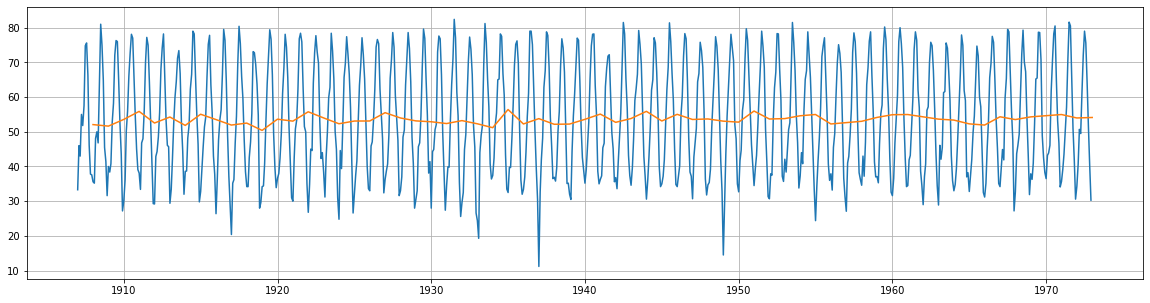

In [14]:
# plot both on same figure
plt.plot(monthly_temp)
plt.plot(annual_temp)
plt.grid();

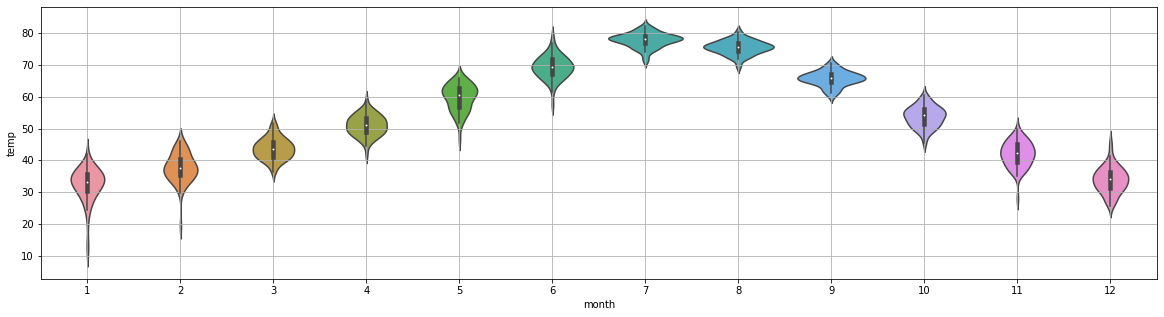

In [15]:
# violinplot of months to determine variance and range
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp)
plt.grid();

15.815451540670232
9.45542698779467
9.25220062434484
14.726150786762325


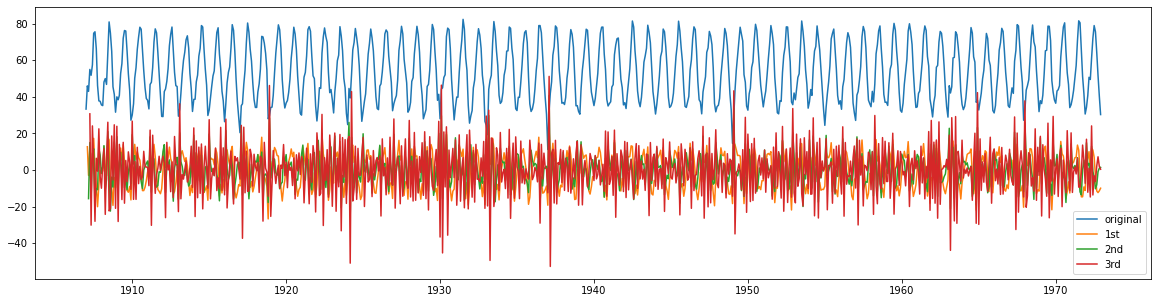

In [16]:
# check montly deviations for various diffs
print(monthly_temp.temp.std())
print(monthly_temp.temp.diff().std())
print(monthly_temp.temp.diff().diff().std()) # theoretically lowest, but > 1 is close enough
print(monthly_temp.temp.diff().diff().diff().std())

plt.figure(figsize=(20,5))
plt.plot(monthly_temp.temp)
plt.plot(monthly_temp.temp.diff())
plt.plot(monthly_temp.temp.diff().diff()) # theoretically lowest, but > 1 is close enough
plt.plot(monthly_temp.temp.diff().diff().diff())
plt.legend(['original','1st','2nd','3rd'])
plt.show()

In [17]:
# check annual deviations for various diffs
print(annual_temp.temp.std()) # looks stationary as is
print(annual_temp.temp.diff().std())
print(annual_temp.temp.diff().diff().std())
print(annual_temp.temp.diff().diff().diff().std())

1.2621242173990006
1.7725607336526374
3.117841613811376
5.803232109414729


In [18]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic         -6.481466e+00
p-value                 1.291867e-08
Lags Used               2.100000e+01
Observations Used       7.700000e+02
Critical Value (1%)    -3.438871e+00
Critical Value (5%)    -2.865301e+00
Critical Value (10%)   -2.568773e+00
dtype: float64


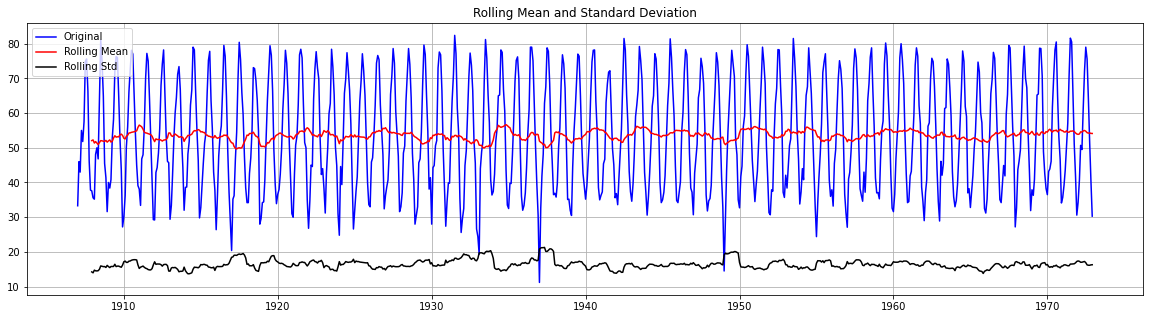

In [19]:
# run DFT on monthly
dftest(monthly_temp.temp)
# p-value allows us to reject a unit root: data is stationary

In my opinion, the monthly data is non-stationary as there is a seasonal component.

Test Statistic         -7.878242e+00
p-value                 4.779473e-12
Lags Used               0.000000e+00
Observations Used       6.500000e+01
Critical Value (1%)    -3.535217e+00
Critical Value (5%)    -2.907154e+00
Critical Value (10%)   -2.591103e+00
dtype: float64


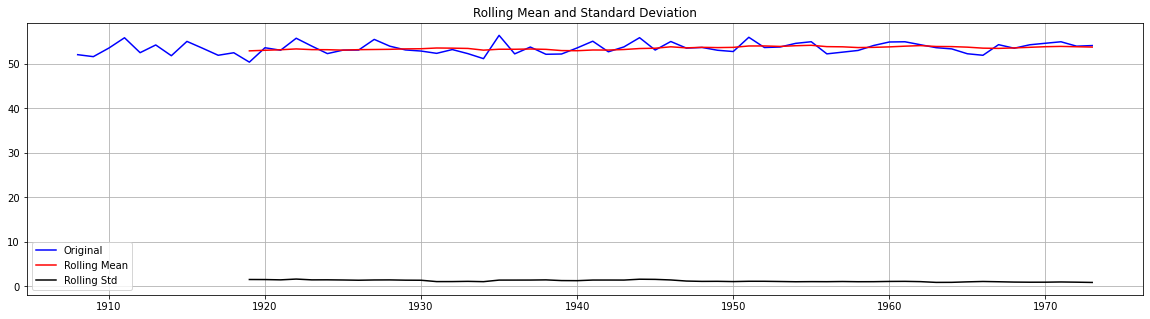

In [20]:
# run DFT on annual
dftest(annual_temp.temp)

The p-value allows us to *reject* a unit root (i.e. the data is stationary).

Test Statistic          -0.449458
p-value                  0.901508
Lags Used               10.000000
Observations Used       55.000000
Critical Value (1%)     -3.555273
Critical Value (5%)     -2.915731
Critical Value (10%)    -2.595670
dtype: float64


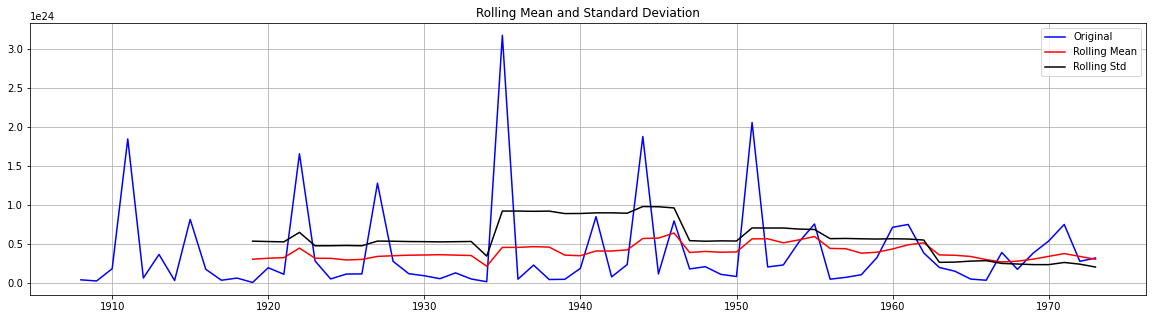

In [21]:
# here's an example of non-stationary with DFT results
dftest(np.exp(annual_temp.temp))

### Create Helper Functions

In [22]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

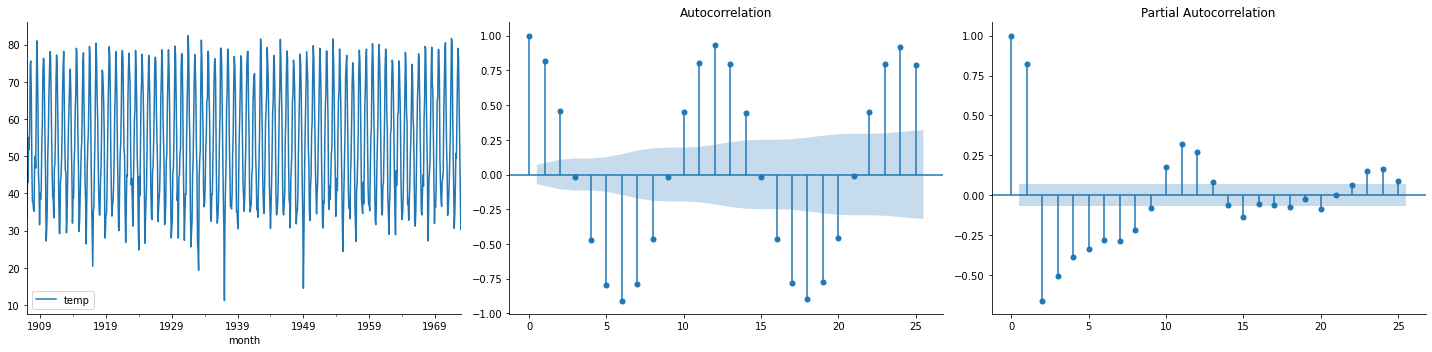

In [23]:
# helper plot for monthly temps
plots(monthly_temp, lags=25);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

I honestly thought maybe avg temp of a year might correlate with previor year. But for annual temp, I don't see any AR or even any MR term. Maybe very high MR terms but not sure they have practical signficance (even though they have some statistical significance)

In [24]:
monthly_diff = monthly_temp.copy()
monthly_diff['diff'] = monthly_diff['temp'].diff()
monthly_diff_1 = monthly_diff.drop('temp', 1).iloc[1:]

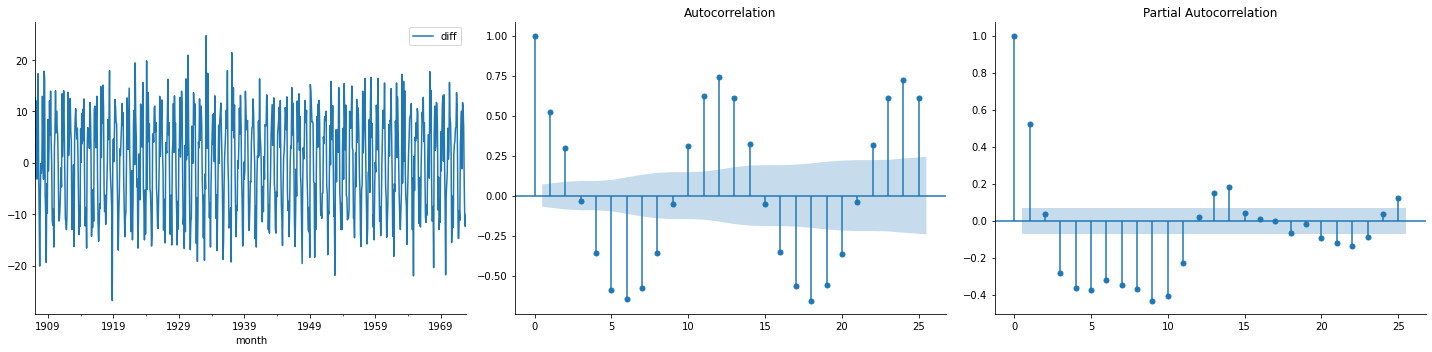

In [25]:
# helper plot for monthly temps
plots(monthly_diff_1, lags=25);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

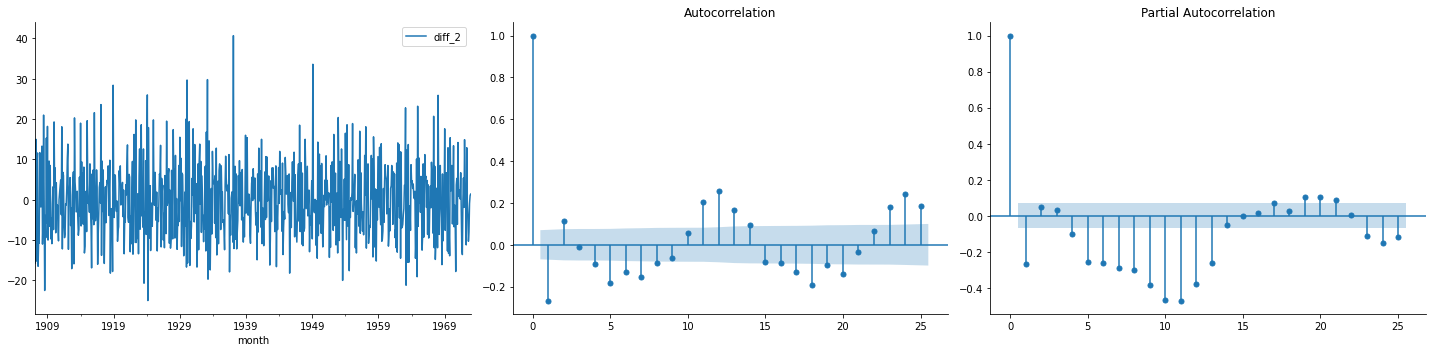

In [26]:
monthly_diff_1['diff_2'] = monthly_diff_1['diff'].diff()
monthly_diff_2 = monthly_diff_1.drop('diff', 1).iloc[1:]
plots(monthly_diff_2, lags=25);

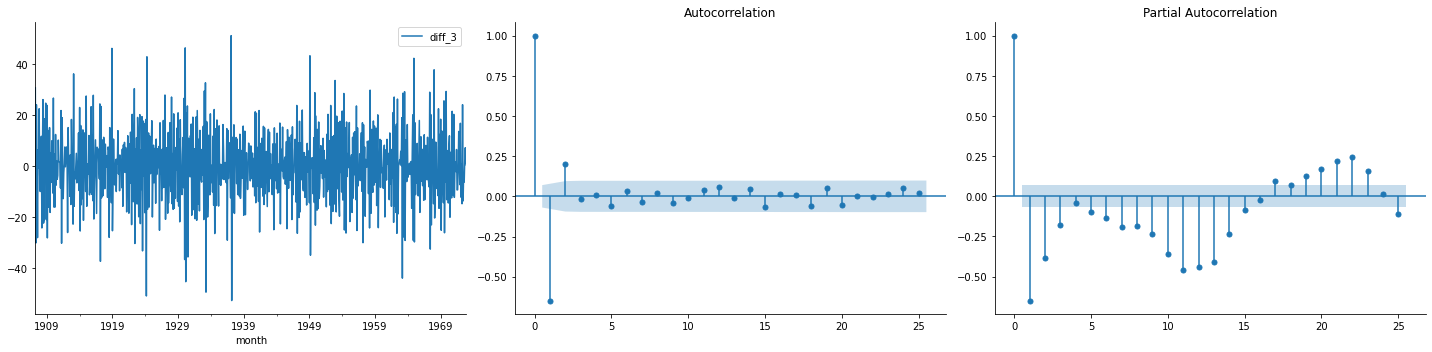

In [27]:
monthly_diff_2['diff_3'] = monthly_diff_2['diff_2'].diff()
monthly_diff_3 = monthly_diff_2.drop('diff_2', 1).iloc[1:]
plots(monthly_diff_3, lags=25);

The diff_3 ACF plot shows over-differencing since lag-1 is greater than 0.5 in absolute terms. Also, we concluded earlier that the lower std is at diff_2. I am not sure why the author of this notebook did not difference before plotting ACF/PACF plots. Maybe, that is because we are building ARIMA model (not ARMA) and we will eventually tell the model to Integrate (I) parameter. Also, looking at this example, I see that even if the data is non-stationary, the plots can show the seasonality terms to be added. I still feel that the books methodology is more straightforward. i.e take the RegSeasDiff and then see what AR/MA terms to add. 

# Proper Textbook Methodology

array([<AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>],
      dtype=object)

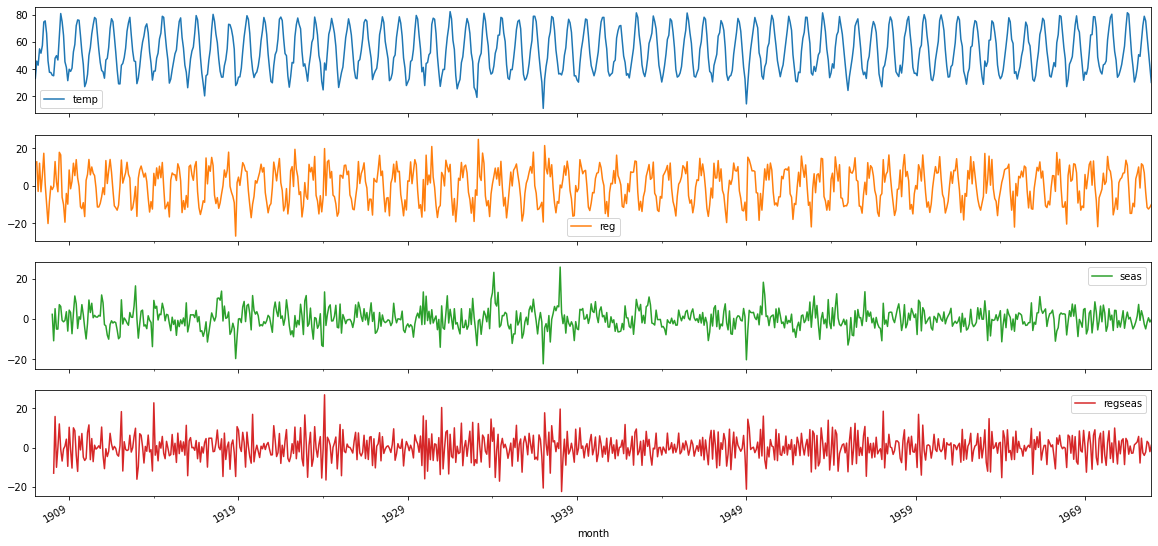

In [28]:
monthly_temp['reg'] = monthly_temp['temp'].diff(1) 
monthly_temp['seas'] = monthly_temp['temp'].diff(12) 
monthly_temp['regseas'] = monthly_temp['seas'].diff(1)
monthly_temp.head(14)

monthly_temp.plot(subplots=True, figsize=(20,10))

Test Statistic         -6.481466e+00
p-value                 1.291867e-08
Lags Used               2.100000e+01
Observations Used       7.700000e+02
Critical Value (1%)    -3.438871e+00
Critical Value (5%)    -2.865301e+00
Critical Value (10%)   -2.568773e+00
dtype: float64


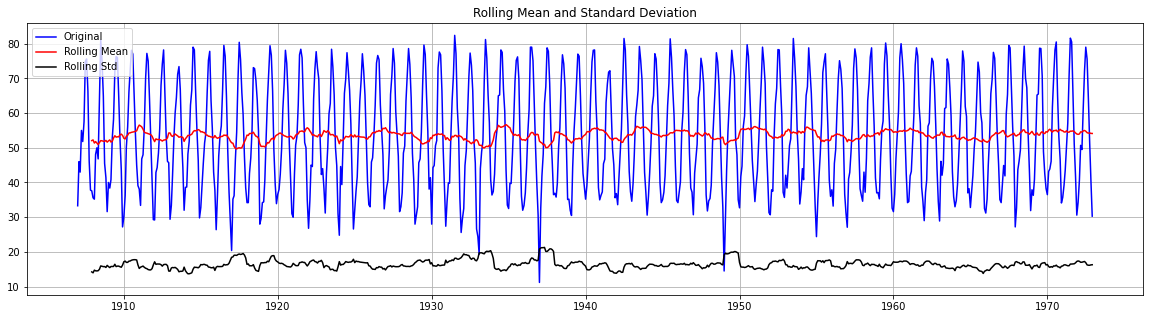

In [29]:
dftest(monthly_temp['temp'])

Test Statistic         -1.230261e+01
p-value                 7.391771e-23
Lags Used               2.100000e+01
Observations Used       7.690000e+02
Critical Value (1%)    -3.438882e+00
Critical Value (5%)    -2.865306e+00
Critical Value (10%)   -2.568775e+00
dtype: float64


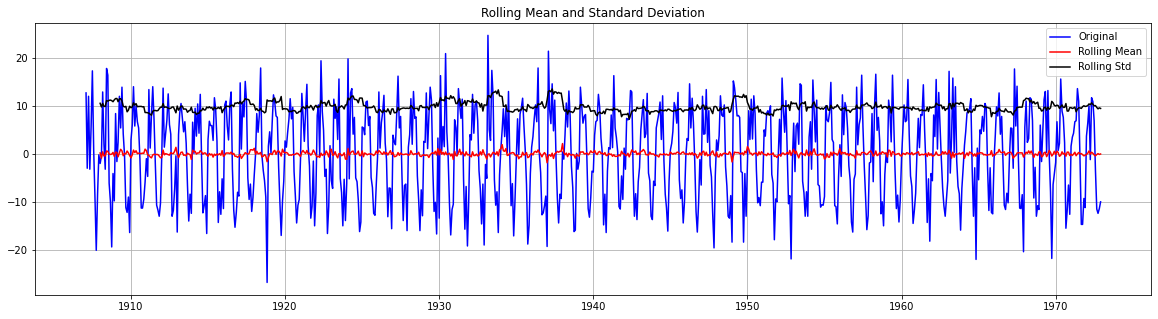

In [30]:
dftest(monthly_temp['reg'].dropna())

Test Statistic         -1.265808e+01
p-value                 1.323220e-23
Lags Used               1.200000e+01
Observations Used       7.670000e+02
Critical Value (1%)    -3.438905e+00
Critical Value (5%)    -2.865316e+00
Critical Value (10%)   -2.568781e+00
dtype: float64


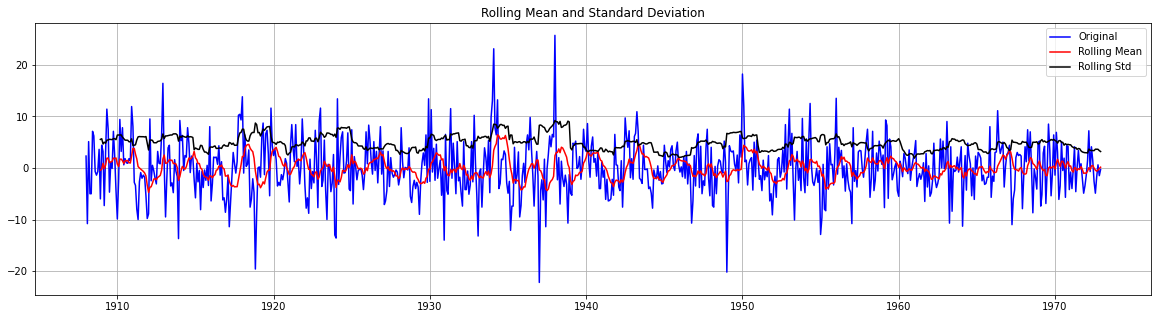

In [31]:
dftest(monthly_temp['seas'].dropna())

Test Statistic         -1.184617e+01
p-value                 7.390517e-22
Lags Used               2.000000e+01
Observations Used       7.580000e+02
Critical Value (1%)    -3.439006e+00
Critical Value (5%)    -2.865361e+00
Critical Value (10%)   -2.568804e+00
dtype: float64


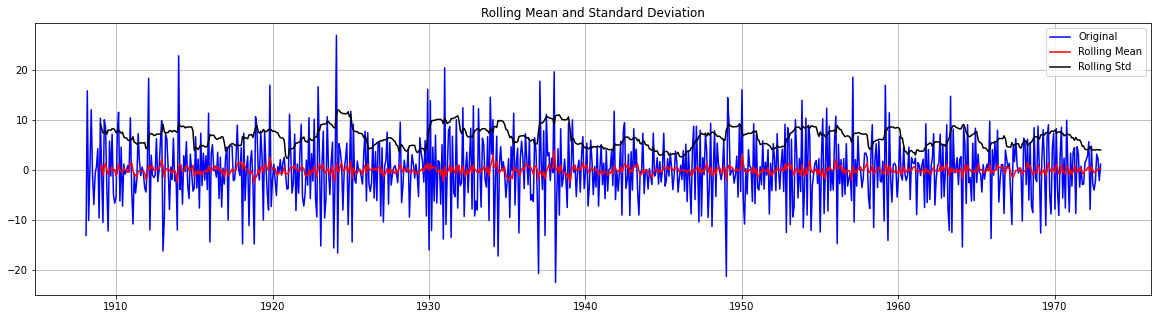

In [32]:
dftest(monthly_temp['regseas'].dropna())

In [33]:
print(monthly_temp['reg'].std())
print(monthly_temp['seas'].std())
print(monthly_temp['regseas'].std())

9.45542698779467
5.228035433877334
6.6519331827


Okay so from the above graphs, we can see that the ADF test is unreliable because it doesn't seem to account for the monthly variations in the data. But it is reliable in the sense that it shows stronger stationary affect in the differences series. By the std rule, maybe the seas difference is good enough (or even better) but we may see short-term trends (stochastic trend effects) and therefore, may want to do a combined regular and seasonal difference (aka RegSeasDiff).

There is no clear cut guideline as to whether we should difference the data before test_train_split or after. Actually, it doesn't even matter. I am going to assume it doesn't and gonna plot ACF/PACF and choose paramaters based on complete dataset but while fitting the model, only use the training part.

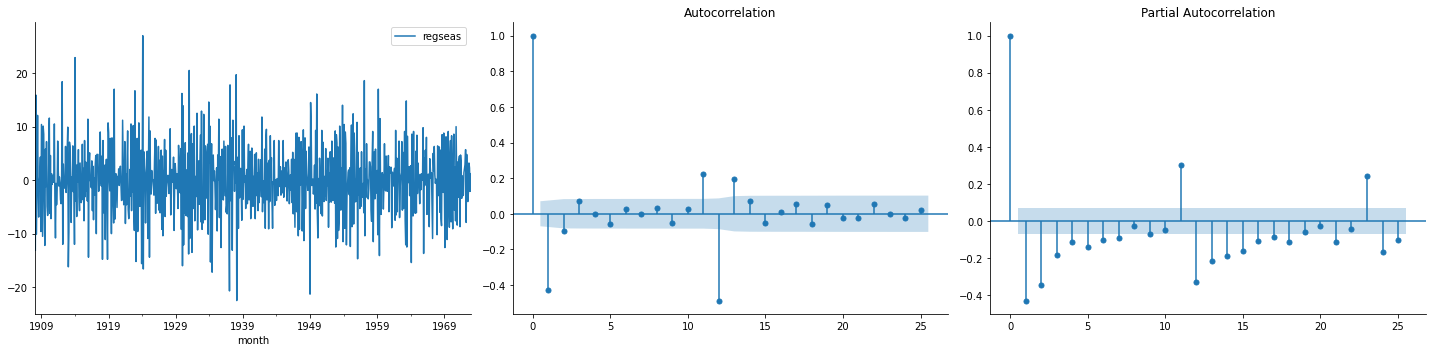

In [34]:
plots(monthly_temp[['regseas']].dropna(), lags=25);

## Based on Box and Jenkin's rules:

Since there are spikes at lag 1, 2, 11, 12 and 13 in ACF and then cuts off; and PACF dies down fairly quickly, this indicates an MA model.

Textbook defines non-seasonal levels of month lags of 1 to 9 and seasonal lags of 12 and 24. Also, it says that it is a general rule to ignore spikes at higher lags in both ACF as well as PACF.

It may correspond to lag 1, lag 2 and lag 12 MA models (ignoring 11 and 13 by above mentioned rules.)

(0,1,2),(0,1,12)

Actually: (0,1,2),(0,1,1,12)

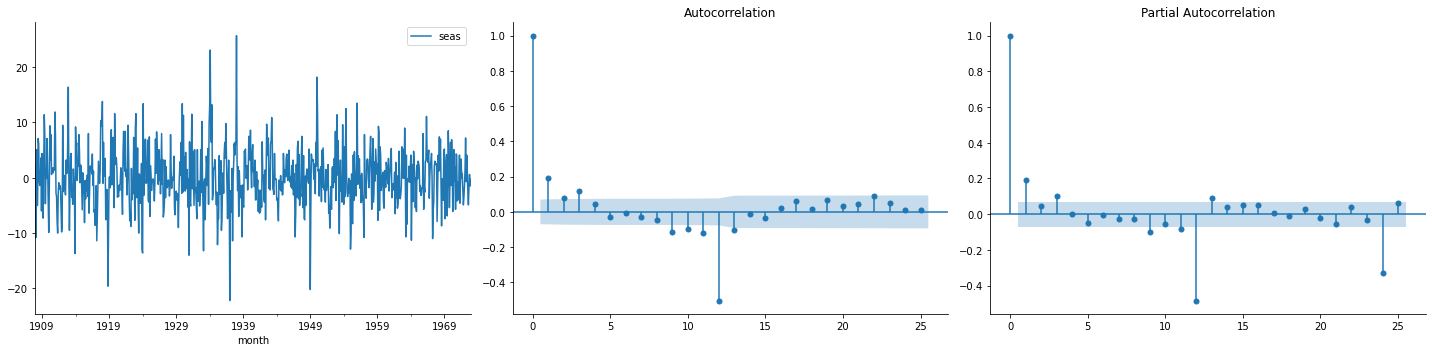

In [35]:
plots(monthly_temp[['seas']].dropna(), lags=25);

By rules:

1. Since lag 1 cuts off in PACF and dies down fairly quickly in ACF, this indicates an AR term: AR(1)
2. For the seasonal level, this still indicates an MA term as autocorrelation at lag 12 cuts off in ACF and dies down fairly qucikly in PACF. So, we'll add MA(12) term in the model.

(1,0,0),(0,1,1,12)

Or actually maybe

((1,3),0,0),(0,1,1,12) because the lag-3 is also significant

These actually makes sense because AR term partially takes a regular difference. In the case where I dont take Regular difference, the outputs tell me to add AR term to compensate for the under-diff.

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

# Model Building

Rule 5: A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend.

In [36]:
from math import floor
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

In [37]:
train = monthly_temp[:floor(0.8*len(monthly_temp))]
test = monthly_temp[floor(0.8*len(monthly_temp)):]

In [38]:
# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(train['temp'], 
                                order=(1,1,0), 
                                seasonal_order=(0,1,0,12), 
                                trend='c').fit()
sar.summary()

C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               temp   No. Observations:                  633
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2011.109
Date:                            Mon, 07 Dec 2020   AIC                           4028.219
Time:                                    21:42:34   BIC                           4041.508
Sample:                                01-01-1907   HQIC                          4033.385
                                     - 09-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.250      0.001      0.999      -0.491       0.491
ar.L1         -0.4321      0.033    -13.260      0.000      -0.496      -0.368
sigma2        38.4454      1.822     21.101      0.000      34.874      42.016
===================================================================================
Ljung-Box (L1) (Q):                  12.87   Jarque-Bera (JB):                23.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.14
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

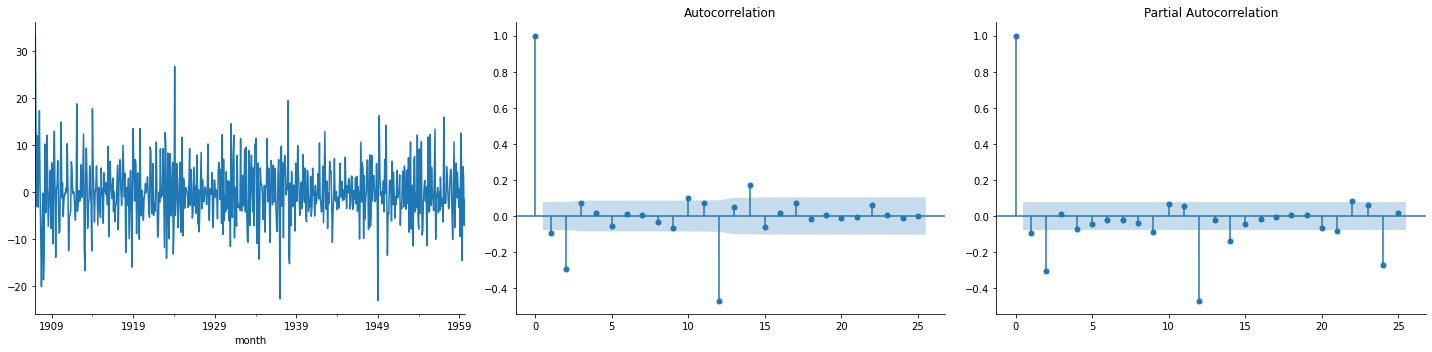

In [39]:
# plot resids
plots(sar.resid, lags=25);

Thought process:  
010010 is overdiff by AIC and negative ACR, but 000010 is a big underdiff with better AIC
we pick 000010,12 and Trend='c' per rule 4/5l

Now look at seasonal. Notice negative ACR spike at 12: per rule 13, we add a SMA term and we see a big drop to 4284 AIC
looks like ACR looks good at seasonal lags, so we move back to ARIMA portion.

Rule 6 says we're a bit underdiff, so we add AR=3 based on PACF: 4261 AIC.

In [40]:
sar_df = train.copy()
sar_df['fits'] = sar.predict(start = 0, end= len(train)-1, dynamic=False)
sar_df['resid'] = sar.resid
sar_df['manual_resid']  = sar_df['temp'] - sar_df['fits']
sar_df[['temp', 'fits', 'resid', 'manual_resid']].head(13)

temp       fits      resid  manual_resid
month                                               
1907-01-01  33.3   0.000169  33.299831     33.299831
1907-02-01  46.0  33.299829  12.700171     12.700171
1907-03-01  43.0  46.000057  -3.000057     -3.000057
1907-04-01  55.0  43.000279  11.999721     11.999721
1907-05-01  51.8  54.999877  -3.199877     -3.199877
1907-06-01  57.5  51.800361   5.699639      5.699639
1907-07-01  74.8  57.499970  17.300030     17.300030
1907-08-01  75.6  74.799902   0.800098      0.800098
1907-09-01  66.3  75.600268  -9.300268     -9.300268
1907-10-01  46.2  66.300316 -20.100316    -20.100316
1907-11-01  37.8  46.200516  -8.400516     -8.400516
1907-12-01  37.6  37.800191  -0.200191     -0.200191
1908-01-01  35.6  54.250474 -18.650474    -18.650474

C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
3878.1440681660424


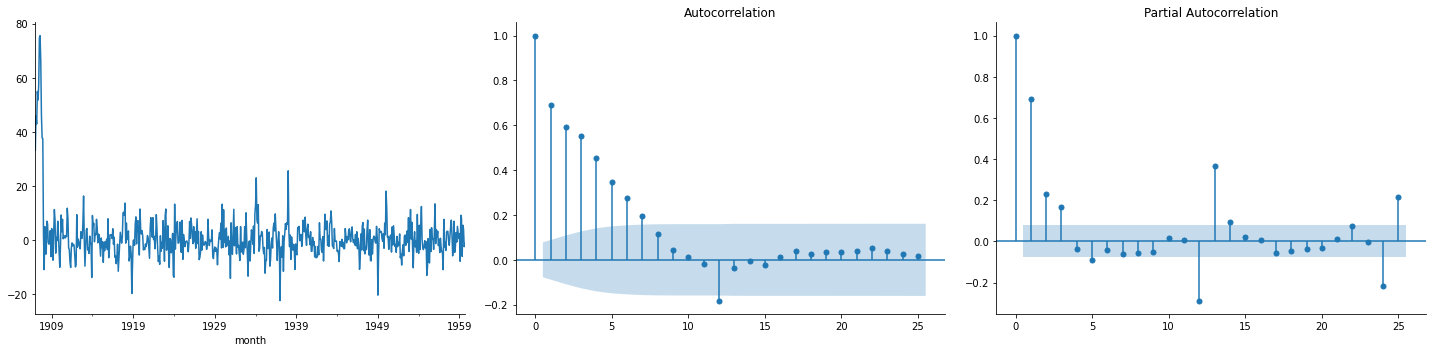

In [41]:
# fit SARIMA monthly based on helper plots
sar_1 = sm.tsa.statespace.SARIMAX(train['temp'], 
                                order=(0,0,0), 
                                seasonal_order=(0,1,0,12), 
                                trend='c').fit()


print(sar_1.aic)

# plot resids
plots(sar_1.resid, lags=25)

C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
4153.774478122332


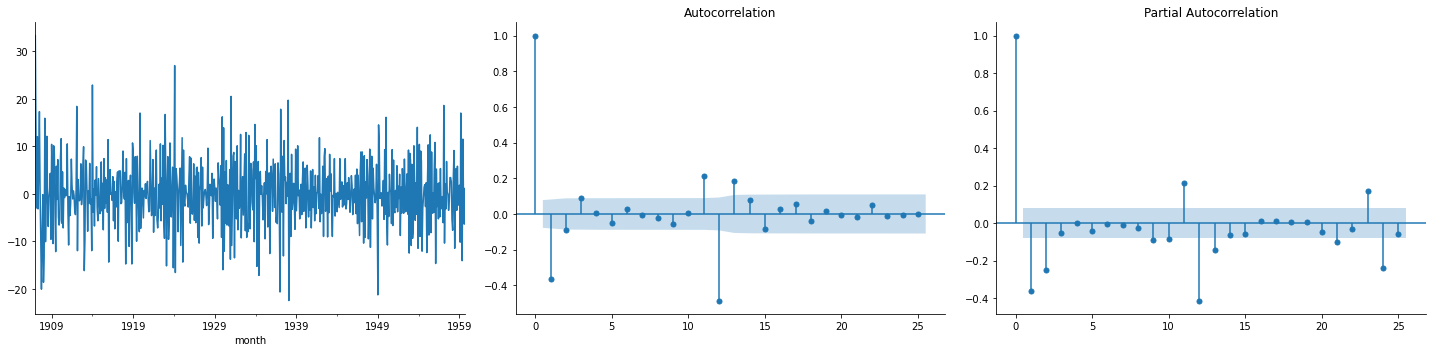

In [42]:
# fit SARIMA monthly based on helper plots
sar_2 = sm.tsa.statespace.SARIMAX(train['temp'], 
                                order=(0,1,0), 
                                seasonal_order=(0,1,0,12), 
                                trend='c').fit()

print(sar_2.aic)

plots(sar_2.resid, lags=25)

In [43]:
# fit SARIMA monthly based on helper plots
author = sm.tsa.statespace.SARIMAX(train['temp'], 
                                order=(3,0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()

author.summary()

C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  633
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1713.708
Date:                              Mon, 07 Dec 2020   AIC                           3439.415
Time:                                      21:43:14   BIC                           3466.003
Sample:                                  01-01-1907   HQIC                          3449.750
                                       - 09-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0128      0.011      1.151      0.250      -0.009       0.035
ar.L1          0.1976      0.041      4.842      0.000       0.118       0.278
ar.L2          0.0145      0.041      0.351      0.726      -0.066       0.095
ar.L3          0.0716      0.041      1.734      0.083      -0.009       0.153
ma.S.L12      -0.9998      4.808     -0.208      0.835     -10.424       8.424
sigma2        13.5253     64.837      0.209      0.835    -113.552     140.603
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               230.60
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

3439.4154640714432


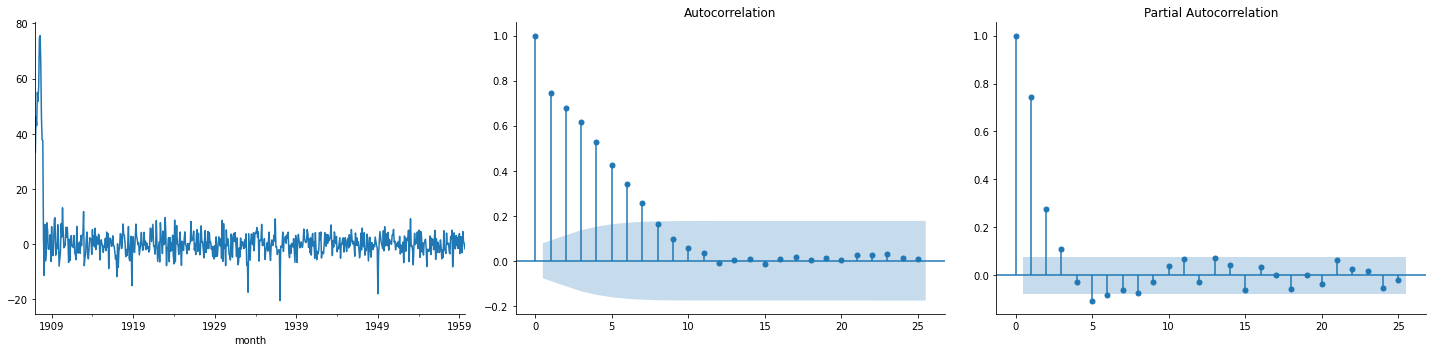

In [44]:
print(author.aic)

plots(author.resid, lags=25)

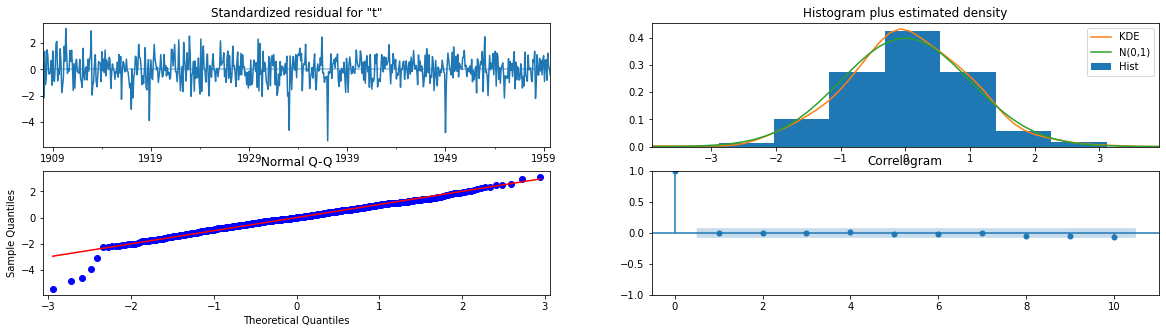

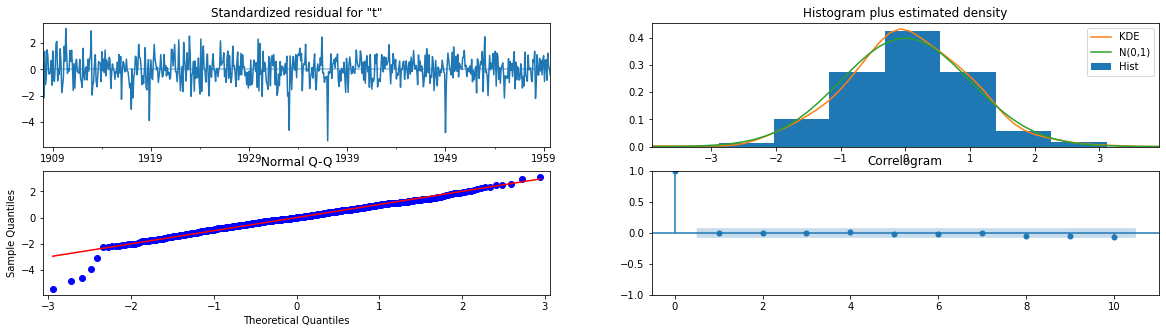

In [45]:
author.plot_diagnostics()

In [46]:
author_df = train.copy()
author_df['fits'] = author.predict(start = 0, end= len(train)-1, dynamic=False)
author_df['resid'] = author.resid
author_df['manual_resid']  = author_df['temp'] - author_df['fits']
author_df[['temp', 'fits', 'resid', 'manual_resid']].head(13)

temp       fits      resid  manual_resid
month                                               
1907-01-01  33.3   0.017854  33.282146     33.282146
1907-02-01  46.0   0.018049  45.981951     45.981951
1907-03-01  43.0   0.018189  42.981811     42.981811
1907-04-01  55.0   0.018279  54.981721     54.981721
1907-05-01  51.8   0.018405  51.781595     51.781595
1907-06-01  57.5   0.018425  57.481575     57.481575
1907-07-01  74.8   0.018487  74.781513     74.781513
1907-08-01  75.6   0.018601  75.581399     75.581399
1907-09-01  66.3   0.018640  66.281360     66.281360
1907-10-01  46.2   0.018590  46.181410     46.181410
1907-11-01  37.8   0.018426  37.781574     37.781574
1907-12-01  37.6   0.018211  37.581789     37.581789
1908-01-01  35.6  33.317616   2.282384      2.282384

<AxesSubplot:xlabel='month'>

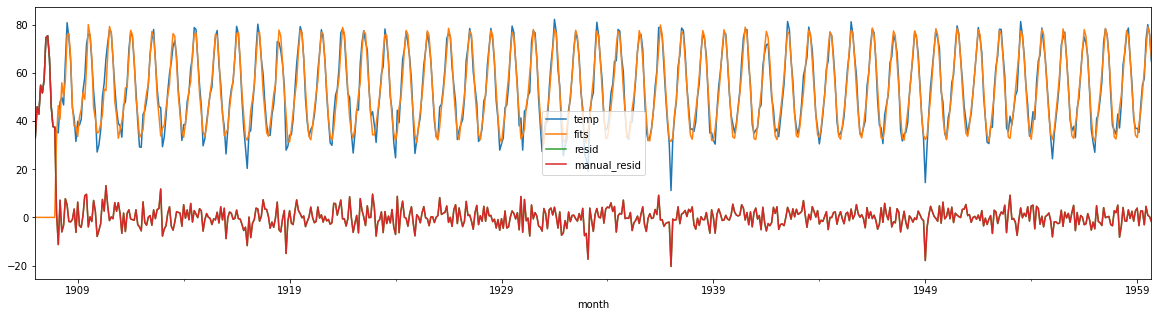

In [47]:
author_df[['temp', 'fits', 'resid', 'manual_resid']].plot()

# Vola!

Now I figure out why there is a spike in the residuals. Because the differenced series starts at a later index, the model is not able to fit for those indexes. So when residuals are calculated, they are invalid for the starting few indices.

In [48]:
np.power(author_df['resid'][13:].std(),2)

# This is much closed to the sigma2 value in the model's summary.

14.933107523627001

<AxesSubplot:xlabel='month'>

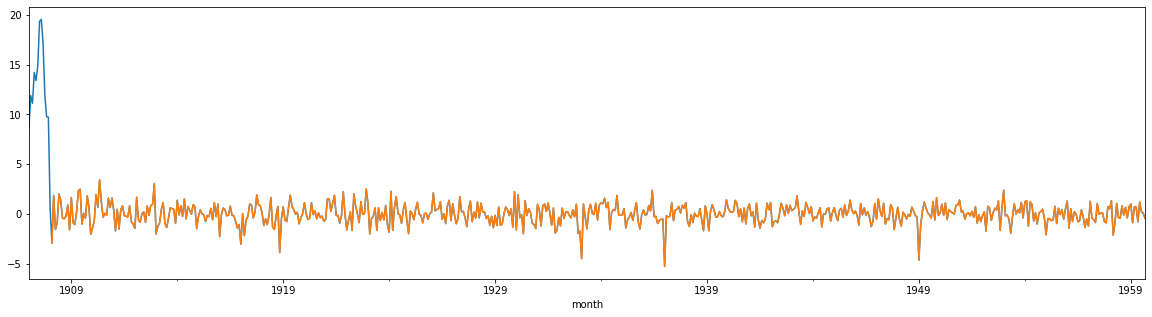

In [49]:
author_df['std_resid'] = (author_df['resid'] - author_df['resid'][13:].mean() ) / author_df['resid'][13:].std()
author_df['std_resid'].plot()
author_df['std_resid'][13:].plot()

This means that the standardized residuals in the plot_diangostics() adjusts or removes these troublesome residuals. This also means that when differencing of any kind is involved, the plot_diangostics() ACF is more reliable than the plot_acf() function.

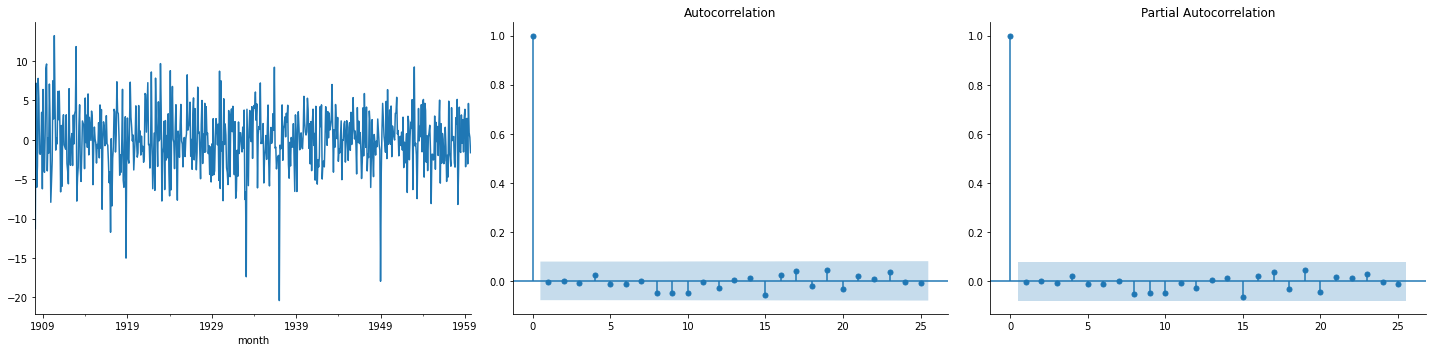

In [50]:
plots(author.resid[13:], lags=25)

# Vola 2.0!

After removing the starting residuals, the plots look exactly like the plot_diagnostics()

## Duke's Methodology

They first build Integration only models and then use the residual ACF and PACF to determine AR and MA terms. The author does something similar but start with AR + I model and then builds the models in a very iterative fashion.

The textbook uses the ACF and PACF of the differenced series.

# Mistake

I added P,D,Q parameters from the reference of non-seasonal parameters. Actually, P,D,Q paramters are themselves at seasonal level. For example, Q=1 correspond to MA(12) term if s=12.

Also, if an iterable is passed instead of integer for pdqPDQ, then the intervening terms can be avoided. For now, I am going to make one change at a time.

In [51]:
model_1_c = sm.tsa.statespace.SARIMAX(train['temp'], 
                                order=(0,1,2), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()
model_1_c.summary()

C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  633
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1719.987
Date:                              Mon, 07 Dec 2020   AIC                           3449.974
Time:                                      21:44:03   BIC                           3472.123
Sample:                                  01-01-1907   HQIC                          3458.583
                                       - 09-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.057e-05      0.000      0.115      0.908      -0.000       0.000
ma.L1         -0.8030      0.091     -8.859      0.000      -0.981      -0.625
ma.L2         -0.1955      0.048     -4.101      0.000      -0.289      -0.102
ma.S.L12      -0.9984      0.511     -1.955      0.051      -1.999       0.002
sigma2        13.7026      6.854      1.999      0.046       0.269      27.136
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               212.40
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
model_1_c_df = train.copy()
model_1_c_df['fits'] = model_1_c.predict(start = 0, end= len(train)-1, dynamic=False)
model_1_c_df['resid'] = model_1_c.resid
model_1_c_df['manual_resid']  = sar_df['temp'] - sar_df['fits']
model_1_c_df[['temp', 'fits', 'resid', 'manual_resid']].head(13)

temp       fits      resid  manual_resid
month                                               
1907-01-01  33.3   0.000021  33.299979     33.299831
1907-02-01  46.0  33.299726  12.700274     12.700171
1907-03-01  43.0  45.999707  -2.999707     -3.000057
1907-04-01  55.0  43.000006  11.999994     11.999721
1907-05-01  51.8  54.999825  -3.199825     -3.199877
1907-06-01  57.5  51.800013   5.699987      5.699639
1907-07-01  74.8  57.499937  17.300063     17.300030
1907-08-01  75.6  74.799684   0.800316      0.800098
1907-09-01  66.3  75.599914  -9.299914     -9.300268
1907-10-01  46.2  66.300181 -20.100181    -20.100316
1907-11-01  37.8  46.200470  -8.400470     -8.400516
1907-12-01  37.6  37.800458  -0.200458     -0.200191
1908-01-01  35.6  54.250067 -18.650067    -18.650474

In [53]:
model_2a = sm.tsa.statespace.SARIMAX(train['temp'], 
                                order=(1,0,0), 
                                seasonal_order=(0,1,1,12)).fit()
model_2a.summary()

C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  633
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1716.666
Date:                              Mon, 07 Dec 2020   AIC                           3439.333
Time:                                      21:44:09   BIC                           3452.627
Sample:                                  01-01-1907   HQIC                          3444.500
                                       - 09-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2100      0.040      5.297      0.000       0.132       0.288
ma.S.L12      -0.9987      0.632     -1.579      0.114      -2.238       0.241
sigma2        13.6719      8.477      1.613      0.107      -2.943      30.287
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               233.34
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
model_2b_c = sm.tsa.statespace.SARIMAX(train['temp'], 
                                order=(3,0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()
model_2b_c.summary()

C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  633
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1713.708
Date:                              Mon, 07 Dec 2020   AIC                           3439.415
Time:                                      21:44:19   BIC                           3466.003
Sample:                                  01-01-1907   HQIC                          3449.750
                                       - 09-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0128      0.011      1.151      0.250      -0.009       0.035
ar.L1          0.1976      0.041      4.842      0.000       0.118       0.278
ar.L2          0.0145      0.041      0.351      0.726      -0.066       0.095
ar.L3          0.0716      0.041      1.734      0.083      -0.009       0.153
ma.S.L12      -0.9998      4.808     -0.208      0.835     -10.424       8.424
sigma2        13.5253     64.837      0.209      0.835    -113.552     140.603
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               230.60
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
model_2c_c = sm.tsa.statespace.SARIMAX(train['temp'], 
                                order=((1,3),0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()
model_2c_c.summary()

C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\shah_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                      temp   No. Observations:                  633
Model:             SARIMAX([1, 3], 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1713.769
Date:                                   Mon, 07 Dec 2020   AIC                           3437.539
Time:                                           21:44:29   BIC                           3459.695
Sample:                                       01-01-1907   HQIC                          3446.151
                                            - 09-01-1959                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0130      0.011      1.170      0.242      -0.009       0.035
ar.L1          0.2004      0.039      5.109      0.000       0.124       0.277
ar.L3          0.0746      0.041      1.807      0.071      -0.006       0.155
ma.S.L12      -0.9996      2.073     -0.482      0.630      -5.062       3.063
sigma2        13.5338     27.863      0.486      0.627     -41.076      68.143
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               234.62
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
model_2c_c_df = train.copy()
model_2c_c_df['fits'] = model_2c_c.predict(start = 0, end= len(train)-1, dynamic=False)
model_2c_c_df['resid'] = model_2c_c.resid
model_2c_c_df['manual_resid']  = sar_df['temp'] - sar_df['fits']
model_2c_c_df[['temp', 'fits', 'resid', 'manual_resid']].head(13)

temp       fits      resid  manual_resid
month                                               
1907-01-01  33.3   0.017910  33.282090     33.299831
1907-02-01  46.0   0.018103  45.981897     12.700171
1907-03-01  43.0   0.018230  42.981770     -3.000057
1907-04-01  55.0   0.018313  54.981687     11.999721
1907-05-01  51.8   0.018439  51.781561     -3.199877
1907-06-01  57.5   0.018452  57.481548      5.699639
1907-07-01  74.8   0.018513  74.781487     17.300030
1907-08-01  75.6   0.018625  75.581375      0.800098
1907-09-01  66.3   0.018657  66.281343     -9.300268
1907-10-01  46.2   0.018607  46.181393    -20.100316
1907-11-01  37.8   0.018453  37.781547     -8.400516
1907-12-01  37.6   0.018248  37.581752     -0.200191
1908-01-01  35.6  33.317659   2.282341    -18.650474

# Fits

In [57]:
from faker import Factory

def generate_colors(n):
    colors = []

    for color in range(n):
        fake = Factory.create()
        colors.append(fake.hex_color())
    
    return colors

sar:  38.796372226267074
forecast_author:  10.483027994309506
forecast_1_c:  10.570572067341335
forecast_2a:  10.71584111363425
forecast_2b_c:  10.483027994309506
forecast_2c_c:  10.446503620588963


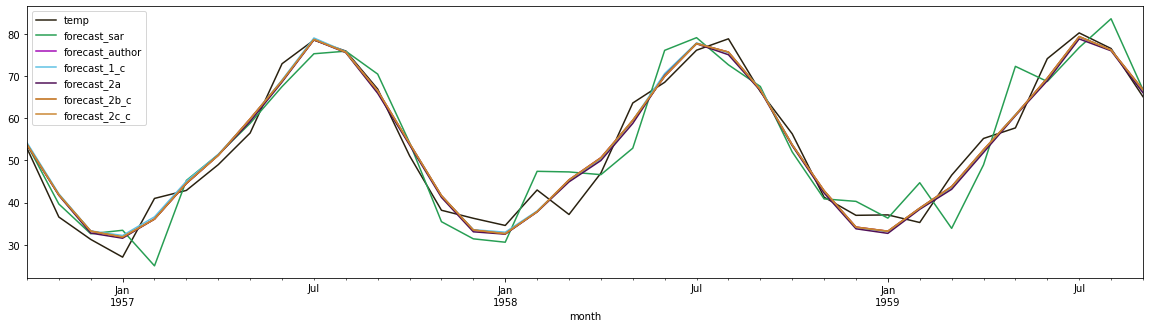

In [58]:
# plot fits

start = len(train) - 36
end = len(train)

train['forecast_sar'] = sar.predict(start = start, end= end, dynamic=False)
train['forecast_author'] = author.predict(start = start, end= end, dynamic=False)
train['forecast_1_c'] = model_1_c.predict(start = start, end= end, dynamic=False)
train['forecast_2a'] = model_2a.predict(start = start, end= end, dynamic=False)
train['forecast_2b_c'] = model_2b_c.predict(start = start, end= end, dynamic=False)
train['forecast_2c_c'] = model_2c_c.predict(start = start, end= end, dynamic=False)

from sklearn.metrics import mean_squared_error
train_nona = train.dropna()

print("sar: ", mean_squared_error(train_nona.temp, train_nona.forecast_sar))
print("forecast_author: ", mean_squared_error(train_nona.temp, train_nona.forecast_author))
print("forecast_1_c: ", mean_squared_error(train_nona.temp, train_nona.forecast_1_c))
print("forecast_2a: ", mean_squared_error(train_nona.temp, train_nona.forecast_2a))
print("forecast_2b_c: ", mean_squared_error(train_nona.temp, train_nona.forecast_2b_c))
print("forecast_2c_c: ", mean_squared_error(train_nona.temp, train_nona.forecast_2c_c))


plot_df = train[len(train)-36:].drop(columns=['reg', 'seas', 'regseas'])

plot_df.plot(color=generate_colors(plot_df.shape[1]));

# Forecasting

In [59]:
test

temp   reg  seas  regseas
month                                
1959-10-01  56.5  -8.6   0.2      1.4
1959-11-01  42.3 -14.2   1.0      0.8
1959-12-01  32.6  -9.7  -4.4     -5.4
1960-01-01  31.6  -1.0  -5.5     -1.1
1960-02-01  36.6   5.0   1.3      6.8
...          ...   ...   ...      ...
1972-08-01  75.6  -3.4  -4.9     -2.3
1972-09-01  64.1 -11.5  -1.7      3.2
1972-10-01  51.7 -12.4   0.6      2.3
1972-11-01  40.3 -11.4  -1.5     -2.1
1972-12-01  30.3 -10.0  -0.3      1.2

[159 rows x 4 columns]

sar:  144.2542705905826
Author:  10.012645776540507
1c:  10.071483574137103
2a:  10.177079220103215
2bc:  10.012645776540507
2cc:  10.013011381088369


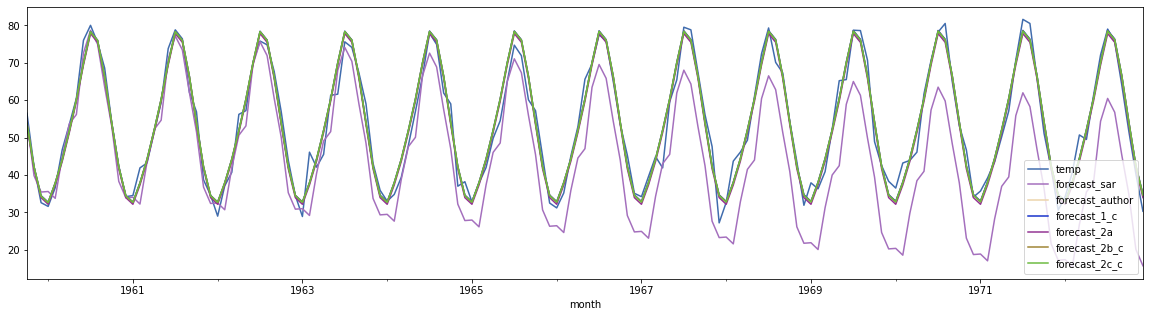

In [60]:
# plot predictions
start = len(train)
end = len(train) + len(test) - 1

test['forecast_sar'] = sar.predict(start = start, end=end, dynamic=False)
test['forecast_author'] = author.predict(start = start, end= end, dynamic=False)
test['forecast_1_c'] = model_1_c.predict(start = start, end= end, dynamic=False)
test['forecast_2a'] = model_2a.predict(start = start, end= end, dynamic=False)
test['forecast_2b_c'] = model_2b_c.predict(start = start, end= end, dynamic=False)
test['forecast_2c_c'] = model_2c_c.predict(start = start, end= end, dynamic=False)

test_nona = test.dropna()
print("sar: ", mean_squared_error(test_nona.temp, test_nona.forecast_sar))
print("Author: ", mean_squared_error(test_nona.temp, test_nona.forecast_author))
print("1c: ", mean_squared_error(test_nona.temp, test_nona.forecast_1_c))
print("2a: ", mean_squared_error(test_nona.temp, test_nona.forecast_2a))
print("2bc: ", mean_squared_error(test_nona.temp, test_nona.forecast_2b_c))
print("2cc: ", mean_squared_error(test_nona.temp, test_nona.forecast_2c_c))

# plt.plot(train.index[len(train) - 36:], train['temp'][len(train) - 36:], 'black')
# plt.plot(test.index[:], test['temp'][:], 'g--')
# plt.plot(forecast_df.index, forecast_df.forecast_sar)
# plt.plot(forecast_df.index, forecast_df.forecast_my_1)
# plt.plot(forecast_df.index, forecast_df.forecast_my_2, 'r-')
# plt.plot(forecast_df.index, forecast_df.forecast_author, 'b--')
# plt.legend(['test', 'train', 'sar', '1', '2', 'author'])

forecast_df = test.drop(columns=['reg', 'seas', 'regseas'])
forecast_df.plot(color=generate_colors(plot_df.shape[1]));

The incomplete model named 'sar' performs poorly wherease all other models do a very good job.

1. Adding an AR term corrects for mild under-differencing, while adding an MA term corrects for mild overdifferencing

2. ACF and PACF plots: "After" a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed. You are already familiar with the ACF plot: it is merely a bar chart of the coefficients of correlation between a time series and lags of itself. The PACF plot is a plot of the partial correlation coefficients between the series and lags of itself.

3.  The model with two orders of differencing assumes that the trend in the series is time-varying, hence it considers the distant future to be much more uncertain than does the model with only one order of differencing. 

4. Which model should we choose? That depends on the assumptions we are comfortable making with respect to the constancy of the trend in the data. The model with only one order of differencing assumes a constant average trend--it is essentially a fine-tuned random walk model with growth--and it therefore makes relatively conservative trend projections. It is also fairly optimistic about the accuracy with which it can forecast more than one period ahead. The model with two orders of differencing assumes a time-varying local trend--it is essentially a linear exponential smoothing model--and its trend projections are somewhat more more fickle. As a general rule in this kind of situation, I would recommend choosing the model with the lower order of differencing, other things being roughly equal. In practice, random-walk or simple-exponential-smoothing models often seem to work better than linear exponential smoothing models.

5.  A forecasting model with a unit root in the estimated MA coefficients is said to be noninvertible, meaning that the residuals of the model cannot be considered as estimates of the "true" random noise that generated the time series.


Source: https://people.duke.edu/~rnau/411arim3.htm


In [61]:
def perform_tests(sar):
    # create and run statistical tests on model
    norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
    lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
    het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

    # we want to look at largest lag for Ljung-Box, so take largest number in series
    # there's intelligence in the method to determine how many lags back to calculate this stat
    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

    return norm_val, norm_p, lb_val, lb_p, het_val, het_p, durbin_watson, sar.aic, sar.bic

In [62]:
test_list = [perform_tests(sar)
, perform_tests(author)
, perform_tests(model_1_c)
, perform_tests(model_2a)
, perform_tests(model_2b_c)
, perform_tests(model_2c_c)]

results_df = pd.DataFrame(test_list, columns=['Jarque-Bera', 'Jarque-Bera p', 'LJung-Box', 'LJung-Box p', 'Hetero', 'Hetero p', 'Durbin Watson','AIC','BIC'], index=['init (sar)', 'author','1c','2a','2bc','2cc'])
results_df

Jarque-Bera  Jarque-Bera p   LJung-Box   LJung-Box p    Hetero  \
init (sar)    23.491023   7.924814e-06  276.560800  8.482145e-45  0.746887   
author       230.597616   8.440418e-51   12.625856  9.718950e-01  0.654134   
1c           212.404920   7.531086e-47   19.780313  7.091982e-01  0.663781   
2a           233.339693   2.142543e-51   17.108509  8.439974e-01  0.672178   
2bc          230.597616   8.440418e-51   12.625856  9.718950e-01  0.654134   
2cc          234.616458   1.131575e-51   13.050593  9.652794e-01  0.655267   

            Hetero p  Durbin Watson          AIC          BIC  
init (sar)  0.036331       2.281446  4028.218955  4041.508113  
author      0.002379       2.004928  3439.415464  3466.003451  
1c          0.003343       1.980689  3449.974062  3472.122660  
2a          0.004443       2.015570  3439.332768  3452.626761  
2bc         0.002379       2.004928  3439.415464  3466.003451  
2cc         0.002478       2.010667  3437.538809  3459.695465

The comment in the cell below may refer to old/deleted models. Anyways, the key notes are:

1. I was able to build a better model than the author in terms of AIC. Model 2c_c. This is when I use the exact methodology as discussed in the book. The author's model is better in termsof MSE of the forecasted values on test set.

1a. If you are unsure about whether to take Reg difference, consider building a model first without it and analyzing its residuals' ACF/PACF. If lag-1 has very high value (close to 1), then that indicates that it calls for a Reg diff. Also, minor underdifference can be compensated by AR term and opposite by MA term.

2. For some reason, when both Reg and Seas differences are involved, only first row has incorrect residual but when only Seas diff is used, the resids are incorrect until the period corresponding to L (no. of seasons.)

3. The LJung Box is not trustworthy. This may be due to the incorrect residuals calculated, as discussed above.

4. The p-values of the terms also seemed to be very unstable as I built various models. As I recall from the textbook, the p-values can not be blindly trusted.

5. Any test can not be blindly trusted as it may be based on several assumptions and may have some cons. For example, being more susceptible to large standard errors.

DW indicates that in terms of no serial autocorrelation, model 2 and author's model are the best and there is more autocorrelation in sar and model 1. Howeer, LJung-Box indicates abnormally low autocorrelation in model 1 and sar whereas high autocorrelation in the other two. Obviously, the two tests seem to be looking at the residuals differently. This contradiction was also found when the ACF/PACF of models' residuals were plotted using plot_diagnostics() and the plot_acf() fucntions. This means that even these two functions have a different methodology of calculating autocorrelations.

Anyways, I decide not to go into how these tests vary and why these two functions give contradictory ACFs. Based on the MSE of the forecasts on the test set, I conclude that author's mode is better that has a slightly low AIC and MSE than the model 2 which is slighly btter in terms of BIC. Model 1 also performs really well though. The test model performs poorly.

### Note on autofit methods
R has an autoARIMA function (and other automagic methods) that gridsearches/optimizes our model hyperparameters for us. Over time, more of these goodies are porting to Python (e.g. statsmodels.tsa.x13 import x13_arima_select_order). While there's nothing wrong with utilizing these resources, the _human makes the final determination!_ Don't become over-reliant on these methods, especially early on when you are grasping the underlying mechanics and theory!

In [158]:
# warnings.filterwarnings(action='ignore')

# # autoselect for monthly, limited to only searching AR and MA parameters: UPDATE MAX_AR AND MA
# autores = sm.tsa.arma_order_select_ic(monthly_temp.temp, 
#                                       ic=['aic', 'bic'], 
#                                       trend='c', 
#                                       max_ar=4, 
#                                       max_ma=4, 
#                                       fit_kw=dict(method='css-mle'))

# print('AIC', autores.aic_min_order) # will use this as inputs for annual (me: why the fuck input the monthly_temp then?)
# print('BIC', autores.bic_min_order)

AIC (4, 2)
BIC (4, 2)


In [56]:
# # SETUP (using itertools to gridsearch solutions)
# import itertools

# #set parameter range; feel free to update these!
# p = q = range(0, 3)
# d = range(0, 2)
# season = 12

# # list of all parameter combos
# pdq = list(itertools.product(p, d, q))
# # same for seasonal variant
# seasonal_pdq = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))]

# print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) , (0, 0, 1, 12)
SARIMAX: (0, 0, 1) , (0, 0, 2, 12)
SARIMAX: (0, 0, 2) , (0, 1, 0, 12)
SARIMAX: (0, 0, 2) , (0, 1, 1, 12)


**Source:* https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [57]:
# # APPLY (find optimal ARIMA for annual_

# # UNCOMMENT THE FOLLOWING TO RUN (note: this can take awhile)
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(annual_temp,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('ARIMA{},{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

ARIMA(0, 0, 0),(0, 0, 0, 12)12 - AIC:704.0414506406978
ARIMA(0, 0, 0),(0, 0, 1, 12)12 - AIC:533.2060340821196
ARIMA(0, 0, 0),(0, 0, 2, 12)12 - AIC:397.5294615808598
ARIMA(0, 0, 0),(0, 1, 0, 12)12 - AIC:214.09868642684884
ARIMA(0, 0, 0),(0, 1, 1, 12)12 - AIC:152.47308269308903
ARIMA(0, 0, 0),(0, 1, 2, 12)12 - AIC:99.19756800383536
ARIMA(0, 0, 0),(1, 0, 0, 12)12 - AIC:219.44507679443387
ARIMA(0, 0, 0),(1, 0, 1, 12)12 - AIC:193.39413533450292
ARIMA(0, 0, 0),(1, 0, 2, 12)12 - AIC:152.546877176228
ARIMA(0, 0, 0),(1, 1, 0, 12)12 - AIC:152.67080609965316
ARIMA(0, 0, 0),(1, 1, 1, 12)12 - AIC:151.4892500512371
ARIMA(0, 0, 0),(1, 1, 2, 12)12 - AIC:96.8334511556798
ARIMA(0, 0, 0),(2, 0, 0, 12)12 - AIC:153.342206806539
ARIMA(0, 0, 0),(2, 0, 1, 12)12 - AIC:152.96789892451068
ARIMA(0, 0, 0),(2, 0, 2, 12)12 - AIC:149.26750165183813
ARIMA(0, 0, 0),(2, 1, 0, 12)12 - AIC:105.79871092851631
ARIMA(0, 0, 0),(2, 1, 1, 12)12 - AIC:107.84529895111977
ARIMA(0, 0, 0),(2, 1, 2, 12)12 - AIC:98.82863583541933
ARIM

## Section 4: ARIMA with Pyflux

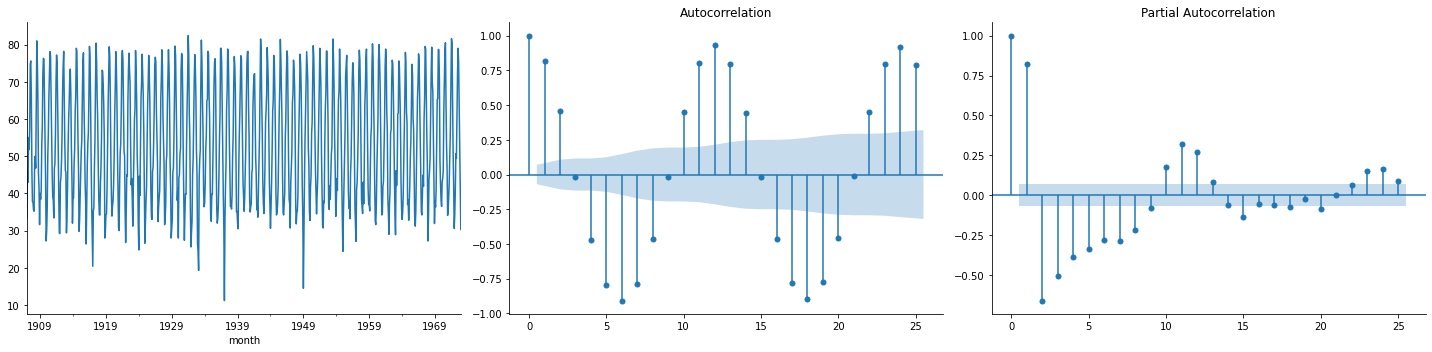

In [58]:
# helper plot
plots(monthly_temp.temp, lags=25)

In [59]:
# build and summarize model
model = pf.ARIMA(data=monthly_temp, ar=2, ma=2, integ=0, target='temp')
x = model.fit("MLE")
x.summary()

Normal ARIMA(2,0,2)                                                                                       
======================================================= ==================================================
Dependent Variable: temp                                Method: MLE                                       
Start Date: 1907-03-01 00:00:00                         Log Likelihood: -2532.0294                        
End Date: 1972-12-01 00:00:00                           AIC: 5076.0587                                    
Number of observations: 790                             BIC: 5104.0909                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 11.5465    0.4337     26.6236  0.0      (10.6965 | 12.3966)      
AR(1)                                

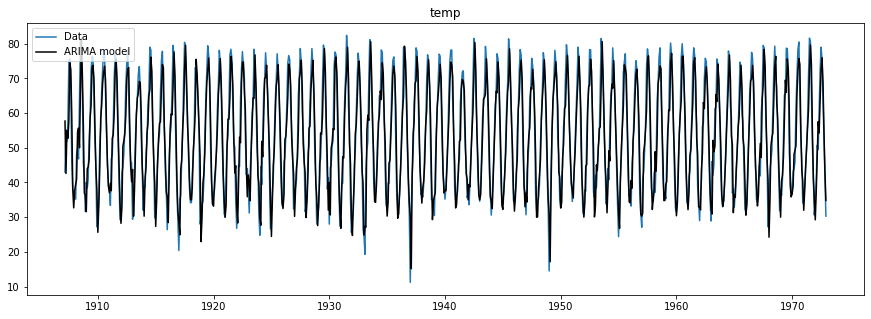

In [61]:
# plot model against raw data
model.plot_fit(figsize=(15,5))

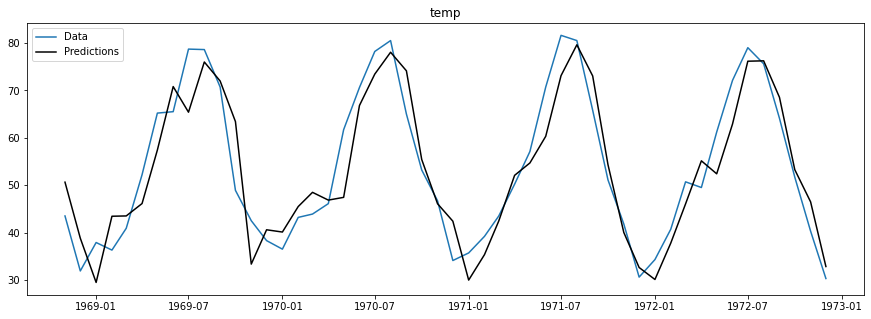

In [62]:
# plot predictions
model.plot_predict_is(50, fit_once=False, figsize=(15,5))

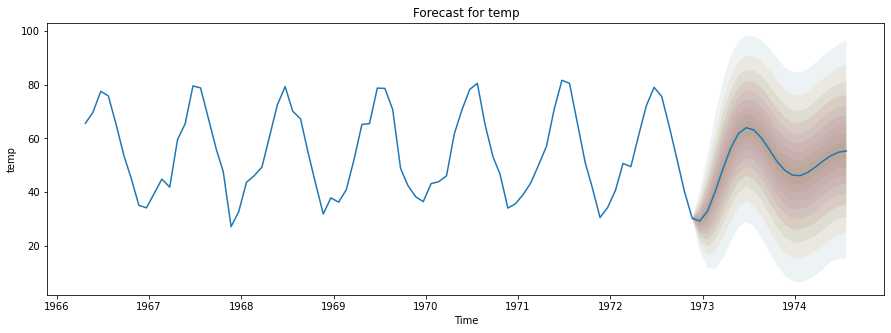

In [63]:
# plot forecast
model.plot_predict(h=20, past_values=80, figsize=(15,5))